# Project 2: HDB price predictor for young families
### Preprocessing and Feature Engineering  

In [ ]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
import scipy.stats as stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from datetime import datetime
from scipy.spatial.distance import cdist
from fuzzywuzzy import process


In [ ]:
# Reading the csv file

hdb_fam = pd.read_csv('../datasets/hdb_fam_clean.csv')

In [ ]:
# Checking the file

hdb_fam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149805 entries, 0 to 149804
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   transact_date    149805 non-null  object 
 1   town             149805 non-null  object 
 2   floor_area_sqm   149805 non-null  float64
 3   resale_price     149805 non-null  float64
 4   storey           149805 non-null  int64  
 5   flat_type        149805 non-null  object 
 6   age              149805 non-null  int64  
 7   lat              149805 non-null  float64
 8   lon              149805 non-null  float64
 9   mall_dist        149805 non-null  float64
 10  hawker_dist      149805 non-null  float64
 11  mrt_dist         149805 non-null  float64
 12  bus_interchange  149805 non-null  int64  
 13  bus_stop_dist    149805 non-null  float64
 14  pri_sch          149805 non-null  object 
 15  pri_sch_lat      149805 non-null  float64
 16  pri_sch_lon      149805 non-null  floa

# Tiering primary schools
---
<font size='2'>To split the list of primary schools in Singapore into three tiers by desirability, we can use the ratio of applications to vacancies as a proxy for desirability. Schools with a higher ratio of applications to vacancies are more popular, indicating higher demand relative to available spots.

Considering the distribution of the popularity ratios and aiming for a method that's straightforward and intuitive, we'll use quantile-based splitting. This approach will divide the schools into three groups based on the popularity ratio, ensuring each tier has roughly the same number of schools. We'll define the tiers as follows:

Tier 1 (High Popularity): Schools in the top third of the popularity ratio distribution.
Tier 2 (Medium Popularity): Schools in the middle third.
Tier 3 (Low Popularity): Schools in the bottom third.</font>

In [ ]:
ballot_df = pd.read_csv('../datasets/p1_ballot_2021.csv')
print(ballot_df.head())

            School  Vacancies  Applications
0      *Admiralty*        210           264
1  *Ahmad Ibrahim*        210            84
2        *Ai Tong*        300           364
3      *Alexandra*        200           223
4   *Anchor Green*        240           271


In [ ]:
# Clean the school names by removing special characters and trimming spaces
ballot_df['School'] = ballot_df['School'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.strip()

# Display all the cleaned school names
cleaned_school_names = ballot_df['School'].unique()
cleaned_school_names.sort()  # Sort the names for easier viewing
cleaned_school_names[:5]

array(['Admiralty', 'Ahmad Ibrahim', 'Ai Tong', 'Alexandra',
       'Anchor Green'], dtype=object)

In [ ]:
# Calculate the popularity metric as the ratio of Applications to Vacancies
ballot_df['Popularity_Ratio'] = ballot_df['Applications'] / ballot_df['Vacancies']

# Display the dataframe with the new column to verify the calculation
ballot_df.head()

,School,Vacancies,Applications,Popularity_Ratio
0,Admiralty,210,264,1.257143
1,Ahmad Ibrahim,210,84,0.400000
2,Ai Tong,300,364,1.213333
3,Alexandra,200,223,1.115000
4,Anchor Green,240,271,1.129167


In [ ]:
# Determine the quantile values for splitting the tiers
quantiles = ballot_df['Popularity_Ratio'].quantile([1/3, 2/3])

# Assign tiers based on quantiles
ballot_df['pri_sch_tier'] = pd.cut(ballot_df['Popularity_Ratio'],
                              bins=[0, quantiles.iloc[0], quantiles.iloc[1], ballot_df['Popularity_Ratio'].max()],
                              labels=['pri_sch_tier_3', 'pri_sch_tier_2', 'pri_sch_tier_1'],
                              include_lowest=True)

# Verify the tier assignments by displaying the first few rows
ballot_df.head()

,School,Vacancies,Applications,Popularity_Ratio,pri_sch_tier
0,Admiralty,210,264,1.257143,pri_sch_tier_1
1,Ahmad Ibrahim,210,84,0.400000,pri_sch_tier_3
2,Ai Tong,300,364,1.213333,pri_sch_tier_1
3,Alexandra,200,223,1.115000,pri_sch_tier_2
4,Anchor Green,240,271,1.129167,pri_sch_tier_2


In [ ]:
# Convert all column names to lower case to maintain consistency
ballot_df.columns = ballot_df.columns.str.lower()

ballot_df.head()

,school,vacancies,applications,popularity_ratio,pri_sch_tier
0,Admiralty,210,264,1.257143,pri_sch_tier_1
1,Ahmad Ibrahim,210,84,0.400000,pri_sch_tier_3
2,Ai Tong,300,364,1.213333,pri_sch_tier_1
3,Alexandra,200,223,1.115000,pri_sch_tier_2
4,Anchor Green,240,271,1.129167,pri_sch_tier_2


In [ ]:
# Normalize the primary school names in the hdb_fam dataset
hdb_fam['pri_sch_name'] = hdb_fam['pri_sch'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.strip()

In [ ]:
# Define a function to perform fuzzy matching and return the best match and its score
def fuzzy_match_school(x, choices, scorer, cutoff):
    match = process.extractOne(x, choices, scorer=scorer, score_cutoff=cutoff)
    return match if match else (None, None)

# Sample some schools for fuzzy matching demonstration
sample_schools = hdb_fam['pri_sch'].sample(n=5, random_state=1).tolist()

# School choices from the original dataset
school_choices = ballot_df['school'].unique()

# Apply fuzzy matching to the sample without specifying a custom scorer
fuzzy_matches = [process.extractOne(school, school_choices, score_cutoff=85) for school in sample_schools]

# Display the sample schools and their fuzzy matches
fuzzy_matches_dict = dict(zip(sample_schools, fuzzy_matches))
fuzzy_matches_dict

{'Rivervale Primary School': ('Rivervale', 90),
 'Elias Park Primary School': ('Elias Park', 90),
 'Cantonment Primary School': ('Cantonment', 90),
 'Keming Primary School': ('Keming', 90),
 "Holy Innocents' Primary School": ('Holy Innocents', 90)}

In [ ]:
# Prepare lists of unique school names from both datasets for fuzzy matching
unique_new_school_names = hdb_fam['pri_sch'].unique()
unique_original_school_names = ballot_df['school'].unique()


# Adjust the fuzzy matching process to properly handle cases where no match meets the score cutoff
match_mapping = {}
for school in unique_new_school_names:
    result = process.extractOne(school, unique_original_school_names, score_cutoff=90)
    if result:
        match, score = result
        match_mapping[school] = match

# Apply the match results to the new dataset
hdb_fam['pri_sch_matched'] = hdb_fam['pri_sch'].map(match_mapping).fillna(hdb_fam['pri_sch'])

# Display the number of matches and some examples for verification
len(match_mapping), list(match_mapping.items())[:5]  # Display the number of matches and a few examples


(163,
 [('Geylang Methodist School', 'Geylang Methodist'),
  ('Kuo Chuan Presbyterian Primary School', 'Kuo Chuan Presbyterian'),
  ('Keming Primary School', 'Keming'),
  ('Catholic High School', 'Catholic High'),
  ('Naval Base Primary School', 'Naval Base')])

In [ ]:
# Apply fuzzy matching to all school names in the new dataset with a score cutoff to filter for scores less than 90
all_school_matches = {school: process.extractOne(school, school_choices, score_cutoff=0) for school in hdb_fam['pri_sch'].unique()}

# Filter matches to only include those with scores less than 90
matches_less_than_90 = {school: match for school, match in all_school_matches.items() if match and match[1] < 90}

matches_less_than_90

{"Saint Margaret's Primary School": ('AngloChinese Primary', 86),
 'Guangyang Primary School': ('Nanyang', 77),
 "Saint Andrew's Junior School": ('Montfort Junior', 86),
 "Saint Hilda's Primary School": ('St Hildas', 80),
 'Eunos Primary School': ('AngloChinese Primary', 57),
 "Saint Anthony's Primary School": ('AngloChinese Primary', 86),
 'Stamford Primary School': ('Pasir Ris', 50),
 'Pioneer Primary School': ('AngloChinese Primary', 57),
 'Juying Primary School': ('Jurong', 60),
 "CHIJ Saint Nicholas Girls' School": ('CHIJ Katong', 86),
 "Saint Anthony's Canossian Primary School": ('AngloChinese Primary', 86),
 "Saint Stephen's School": ('St Stephens', 82),
 'CHIJ Primary': ('AngloChinese Primary', 86),
 "Saint Gabriel's Primary School": ('AngloChinese Primary', 86)}

In [ ]:
# Correction mapping
correction_mapping = {
    "Saint Margarets Primary School": "St Margarets",
    "Saint Andrews Junior School": "St Andrews Junior",
    "CHIJ Saint Nicholas Girls School": "CHIJ St Nicholas Girls",
    "Saint Anthonys Canossian Primary School": "St Anthonys Canossian",
    "Saint Hilda's Primary School": "St Hildas"
}

In [ ]:
# Applying corrections to the 'pri_sch' column
hdb_fam['pri_sch'] = hdb_fam['pri_sch'].apply(lambda x: correction_mapping.get(x, x))
hdb_fam.head()

,transact_date,town,floor_area_sqm,resale_price,storey,flat_type,age,lat,lon,mall_dist,hawker_dist,mrt_dist,bus_interchange,bus_stop_dist,pri_sch,pri_sch_lat,pri_sch_lon,pri_sch_name,pri_sch_matched
0,2016-05-01,KALLANG/WHAMPOA,90.0,680000.0,11,4 ROOM,15,1.314299,103.872828,1094.090418,154.753357,330.083069,0,29.427395,Geylang Methodist School,1.317659,103.882504,Geylang Methodist School,Geylang Methodist
1,2012-07-01,BISHAN,130.0,665000.0,8,5 ROOM,34,1.346086,103.855078,866.941448,640.151925,903.659703,1,58.207761,Kuo Chuan Presbyterian Primary School,1.349783,103.854529,Kuo Chuan Presbyterian Primary School,Kuo Chuan Presbyterian
2,2013-07-01,BUKIT BATOK,144.0,838000.0,14,EXECUTIVE,24,1.343867,103.760535,1459.579948,1762.082341,1334.251197,1,214.747860,Keming Primary School,1.345245,103.756265,Keming Primary School,Keming
3,2012-04-01,BISHAN,103.0,550000.0,3,4 ROOM,29,1.358245,103.845504,950.175199,726.215262,907.453484,1,43.396521,Catholic High School,1.354789,103.844934,Catholic High School,Catholic High
4,2017-12-01,YISHUN,83.0,298000.0,2,4 ROOM,34,1.414745,103.835532,729.771895,1540.151439,412.343032,0,129.422752,Naval Base Primary School,1.416280,103.838798,Naval Base Primary School,Naval Base


In [ ]:
# Merge the tier information from the original dataset into the new dataset based on the matched school names
hdb_fam = pd.merge(hdb_fam, ballot_df[['school', 'pri_sch_tier']], left_on='pri_sch_matched', right_on='school', how='left')

# Display a few rows of the merged dataset to verify the tier information has been correctly merged
hdb_fam[['pri_sch', 'pri_sch_matched', 'school', 'pri_sch_tier']].sample(10)

,pri_sch,pri_sch_matched,school,pri_sch_tier
4669,Xingnan Primary School,Xingnan,Xingnan,pri_sch_tier_3
85523,Punggol Primary School,Punggol,Punggol,pri_sch_tier_1
23153,Xinmin Primary School,Xinmin,Xinmin,pri_sch_tier_1
87229,Northoaks Primary School,Northoaks,Northoaks,pri_sch_tier_3
143800,Red Swastika School,Red Swastika,Red Swastika,pri_sch_tier_1
48736,Frontier Primary School,Frontier,Frontier,pri_sch_tier_1
33551,Damai Primary School,Damai,Damai,pri_sch_tier_3
53530,Westwood Primary School,Westwood,Westwood,pri_sch_tier_1
149458,CHIJ,CHIJ Katong,CHIJ Katong,pri_sch_tier_2
113345,Pei Tong Primary School,Pei Tong,Pei Tong,pri_sch_tier_3


In [ ]:
# Count the null values in the 'pri_sch_tier' column before dropping NaN values
null_tier_count = hdb_fam['pri_sch_tier'].isnull().sum()

null_tier_count

8572

In [ ]:
# Drop rows with NaN values in the 'pri_sch_tier' column to clean the dataset
hdb_fam_clean = hdb_fam.dropna(subset=['pri_sch_tier'])

# Perform one-hot encoding on the 'pri_sch_tier' column, dropping the first category to avoid multicollinearity
pri_sch_tier_one_hot = pd.get_dummies(hdb_fam_clean['pri_sch_tier'], drop_first=True)

# Join the one-hot encoded pri_sch_tiers back to the cleaned dataset
hdb_fam = hdb_fam_clean.join(pri_sch_tier_one_hot, lsuffix='_clean', rsuffix='_one_hot')


In [ ]:
hdb_fam.columns

Index(['transact_date', 'town', 'floor_area_sqm', 'resale_price', 'storey',
       'flat_type', 'age', 'lat', 'lon', 'mall_dist', 'hawker_dist',
       'mrt_dist', 'bus_interchange', 'bus_stop_dist', 'pri_sch',
       'pri_sch_lat', 'pri_sch_lon', 'pri_sch_name', 'pri_sch_matched',
       'school', 'pri_sch_tier', 'pri_sch_tier_2', 'pri_sch_tier_1'],
      dtype='object')

In [ ]:
# Display a few rows of the final dataset to verify the one-hot encoding
hdb_fam[['pri_sch', 'pri_sch_lat', 'pri_sch_lon', 'pri_sch_name', 'pri_sch_matched', 'school', 'pri_sch_tier', 'pri_sch_tier_2', 'pri_sch_tier_1']].head()

# Drop the specified columns from the merged data
hdb_fam = hdb_fam.drop(columns=['pri_sch_name', 'pri_sch_matched', 'school', 'pri_sch_tier'])

# Display a few rows of the dataset after dropping the specified columns to verify
hdb_fam.sample(10)

,transact_date,town,floor_area_sqm,resale_price,storey,flat_type,age,lat,lon,mall_dist,hawker_dist,mrt_dist,bus_interchange,bus_stop_dist,pri_sch,pri_sch_lat,pri_sch_lon,pri_sch_tier_2,pri_sch_tier_1
136186,2017-03-01,JURONG WEST,67.0,347000.0,20,3 ROOM,9,1.337855,103.721463,350.946173,351.353386,693.135189,0,49.850674,Lakeside Primary School,1.338376,103.718051,False,True
94349,2021-03-01,SERANGOON,99.0,620000.0,5,4 ROOM,22,1.355062,103.870872,497.384105,1032.607986,522.368219,1,147.458217,Zhonghua Primary School,1.360167,103.869696,False,False
115840,2015-01-01,PUNGGOL,90.0,427000.0,17,4 ROOM,18,1.399007,103.906991,801.350418,3773.979132,837.764962,1,44.362000,Edgefield Primary School,1.400298,103.907431,True,False
47484,2012-05-01,JURONG WEST,67.0,295000.0,8,3 ROOM,50,1.333184,103.724354,470.473849,346.509982,1265.064126,0,81.892550,Lakeside Primary School,1.338376,103.718051,False,True
28114,2013-03-01,SERANGOON,104.0,590000.0,8,4 ROOM,36,1.355111,103.869935,535.260014,988.314565,579.531995,1,72.072286,Zhonghua Primary School,1.360167,103.869696,False,False
145646,2020-06-01,JURONG WEST,112.0,480000.0,2,5 ROOM,6,1.348097,103.709411,390.341840,493.608061,1135.511858,1,142.151173,Corporation Primary School,1.351485,103.707578,False,False
94343,2017-10-01,BUKIT PANJANG,155.0,580000.0,2,EXECUTIVE,32,1.386221,103.769484,299.320460,938.524980,1161.359513,1,220.898414,Greenridge Primary School,1.385874,103.767815,False,False
128853,2014-02-01,JURONG WEST,110.0,500000.0,11,5 ROOM,20,1.340513,103.698882,239.007501,1641.726873,402.010409,0,46.683592,Jurong West Primary School,1.339244,103.698896,True,False
67315,2020-06-01,PUNGGOL,130.0,558000.0,14,EXECUTIVE,18,1.395800,103.907556,524.013920,3580.687892,1175.385502,1,207.868078,Mee Toh School,1.394854,103.908573,False,True
29041,2018-08-01,HOUGANG,122.0,575000.0,8,5 ROOM,29,1.372368,103.897355,324.087438,1628.422238,489.935041,1,46.609762,CHIJ Our Lady of The Nativity,1.373174,103.897659,True,False


In [ ]:
# Convert the one-hot encoded tier columns to integers
tier_columns = ['pri_sch_tier_2', 'pri_sch_tier_1']
hdb_fam[tier_columns] = hdb_fam[tier_columns].astype(int)

# Verify the data types of the tier columns and display a few rows to confirm
hdb_fam[tier_columns].dtypes, hdb_fam[['pri_sch', *tier_columns]].sample(10)


(pri_sch_tier_2    int64
 pri_sch_tier_1    int64
 dtype: object,
                               pri_sch  pri_sch_tier_2  pri_sch_tier_1
 90520        Seng Kang Primary School               0               0
 90191          Peiying Primary School               1               0
 10585   Tampines North Primary School               0               0
 108726               Poi Ching School               0               1
 141751      Springdale Primary School               1               0
 30394     Yio Chu Kang Primary School               0               0
 84268     North Spring Primary School               0               0
 106048   Punggol Green Primary School               0               1
 135918         Zhangde Primary School               1               0
 128966       Endeavour Primary School               0               0)

In [ ]:
# Checking number of columns
hdb_fam.columns.value_counts().sum()

19

### One Hot encoding for flat types
---

In [ ]:
hdb_fam.columns

Index(['transact_date', 'town', 'floor_area_sqm', 'resale_price', 'storey',
       'flat_type', 'age', 'lat', 'lon', 'mall_dist', 'hawker_dist',
       'mrt_dist', 'bus_interchange', 'bus_stop_dist', 'pri_sch',
       'pri_sch_lat', 'pri_sch_lon', 'pri_sch_tier_2', 'pri_sch_tier_1'],
      dtype='object')

In [ ]:
# Perform one-hot encoding on the 'flat_type' column and drop the first column
flat_type_dummies = pd.get_dummies(hdb_fam['flat_type'], drop_first=True, dtype=int)

# Concatenate the original DataFrame with the new dummy variables
hdb_fam = pd.concat([hdb_fam, flat_type_dummies], axis=1)

# Convert all column headers to lowercase
hdb_fam.columns = hdb_fam.columns.str.lower()

# Drop the original 'flat_type' column
hdb_fam.drop('flat_type', axis=1, inplace=True)

# Display the first few rows to confirm the changes
hdb_fam.head()

,transact_date,town,floor_area_sqm,resale_price,storey,age,lat,lon,mall_dist,hawker_dist,...,pri_sch_lat,pri_sch_lon,pri_sch_tier_2,pri_sch_tier_1,2 room,3 room,4 room,5 room,executive,multi-generation
0,2016-05-01,KALLANG/WHAMPOA,90.0,680000.0,11,15,1.314299,103.872828,1094.090418,154.753357,...,1.317659,103.882504,1,0,0,0,1,0,0,0
1,2012-07-01,BISHAN,130.0,665000.0,8,34,1.346086,103.855078,866.941448,640.151925,...,1.349783,103.854529,1,0,0,0,0,1,0,0
2,2013-07-01,BUKIT BATOK,144.0,838000.0,14,24,1.343867,103.760535,1459.579948,1762.082341,...,1.345245,103.756265,0,1,0,0,0,0,1,0
3,2012-04-01,BISHAN,103.0,550000.0,3,29,1.358245,103.845504,950.175199,726.215262,...,1.354789,103.844934,0,1,0,0,1,0,0,0
4,2017-12-01,YISHUN,83.0,298000.0,2,34,1.414745,103.835532,729.771895,1540.151439,...,1.416280,103.838798,1,0,0,0,1,0,0,0


In [ ]:
hdb_fam.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141233 entries, 0 to 149804
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   transact_date     141233 non-null  object 
 1   town              141233 non-null  object 
 2   floor_area_sqm    141233 non-null  float64
 3   resale_price      141233 non-null  float64
 4   storey            141233 non-null  int64  
 5   age               141233 non-null  int64  
 6   lat               141233 non-null  float64
 7   lon               141233 non-null  float64
 8   mall_dist         141233 non-null  float64
 9   hawker_dist       141233 non-null  float64
 10  mrt_dist          141233 non-null  float64
 11  bus_interchange   141233 non-null  int64  
 12  bus_stop_dist     141233 non-null  float64
 13  pri_sch           141233 non-null  object 
 14  pri_sch_lat       141233 non-null  float64
 15  pri_sch_lon       141233 non-null  float64
 16  pri_sch_tier_2    141233 

### One hot encoding town feature
---

In [ ]:
# Perform one-hot encoding on the 'town' column and drop the first column
town_dummies = pd.get_dummies(hdb_fam['town'], drop_first=True, dtype=int)

# Concatenate the original DataFrame with the new dummy variables
hdb_fam = pd.concat([hdb_fam, town_dummies], axis=1)

# Convert all column headers to lowercase
hdb_fam.columns = hdb_fam.columns.str.lower()

# Drop the original 'town' column
hdb_fam.drop('town', axis=1, inplace=True)

# Display the first few rows to confirm the changes
hdb_fam.head()

,transact_date,floor_area_sqm,resale_price,storey,age,lat,lon,mall_dist,hawker_dist,mrt_dist,...,pasir ris,punggol,queenstown,sembawang,sengkang,serangoon,tampines,toa payoh,woodlands,yishun
0,2016-05-01,90.0,680000.0,11,15,1.314299,103.872828,1094.090418,154.753357,330.083069,...,0,0,0,0,0,0,0,0,0,0
1,2012-07-01,130.0,665000.0,8,34,1.346086,103.855078,866.941448,640.151925,903.659703,...,0,0,0,0,0,0,0,0,0,0
2,2013-07-01,144.0,838000.0,14,24,1.343867,103.760535,1459.579948,1762.082341,1334.251197,...,0,0,0,0,0,0,0,0,0,0
3,2012-04-01,103.0,550000.0,3,29,1.358245,103.845504,950.175199,726.215262,907.453484,...,0,0,0,0,0,0,0,0,0,0
4,2017-12-01,83.0,298000.0,2,34,1.414745,103.835532,729.771895,1540.151439,412.343032,...,0,0,0,0,0,0,0,0,0,1


### Feature Engineering

**Step 1**
<br>Engineering the dist_from_city_centre feature:
<br>
<br>To calculate this distance, we need a reference point that represents the city centre. Commonly, the Central Business District (CBD) coordinates are used as the city centre's location for such calculations. For Singapore, a common reference point is around the coordinates latitude 1.2831° N and longitude 103.8511° E, which is near the Raffles Place area, often considered the heart of the CBD.

In [ ]:
# Define the coordinates for the Central Business District (CBD)
cbd_coordinates = (1.2831, 103.8511)

# Define a function to calculate distance using the Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0
    # Convert latitude and longitude from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Difference in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

# Recalculate distances using the Haversine formula
hdb_fam.loc[:,'cbd_dist_km'] = hdb_fam.apply(
    lambda row: haversine(row['lat'], row['lon'], cbd_coordinates[0], cbd_coordinates[1]),
    axis=1
)

# Display the first few rows to confirm the new distance calculations
hdb_fam[['lat', 'lon', 'cbd_dist_km']].head()


,lat,lon,cbd_dist_km
0,1.314299,103.872828,4.227211
1,1.346086,103.855078,7.017668
2,1.343867,103.760535,12.125001
3,1.358245,103.845504,8.378885
4,1.414745,103.835532,14.740182


**Step 2:**
<br>Primary school proximity advantage
<br>
<br>Priority is given to Singapore Citizens and Permanent Residents who live closer to the preferred school when balloting. Find out how it works.
<br>
<br>If your chosen primary school has more registrants than vacancies, priority admission will be given based on your child's citizenship and the Home-School Distance category, which is in turn based on the address used for registration.
<br>
* Priority admission is given in this order:
* Singapore Citizens (SC) living within 1km of the school.
* SCs living between 1km and 2km of the school.
* SCs living outside 2km of the school.
* Permanent Residents (PR) living within 1km of the school.
* PRs living between 1km and 2km of the school.
* PRs living outside 2km of the school.

<br>Source: https://www.moe.gov.sg/primary/p1-registration/distance

In [ ]:
pri_sch_loc = hdb_fam.groupby('pri_sch').agg({'pri_sch_lat': 'first', 'pri_sch_lon': 'first'})
pri_sch_loc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 163 entries, Admiralty Primary School to Zhonghua Primary School
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pri_sch_lat  163 non-null    float64
 1   pri_sch_lon  163 non-null    float64
dtypes: float64(2)
memory usage: 3.8+ KB


In [ ]:
# Calculate the distances between each property unit and each primary school
distances = cdist(hdb_fam[['lat', 'lon']], pri_sch_loc[['pri_sch_lat', 'pri_sch_lon']])

# Get the indices of the three nearest schools for each property unit
nearest_school_indices = np.argsort(distances, axis=1)[:, :3]

# Get the distances to the three nearest schools
nearest_distances = np.take_along_axis(distances, nearest_school_indices, axis=1)

# Aggregate the distances (e.g., calculate the average distance)
hdb_fam['dist_to_3_psch_avg'] = np.mean(nearest_distances, axis=1)

**Step 3:**
<br> Feature interactions:
1. Product of distance to city centre and age
2. Product of age (years of lease left) and floor area
2. Product of age and storey
3. Average of distance to bus stop, mrt, hawker and mall

In [ ]:
# Before working on feature interactions, recording the existing model's performance in predicting resale value

# Creating X variables
hdb_num = hdb_fam.select_dtypes(include=['number'])
X = hdb_num.drop(columns=['resale_price', 'lat', 'lon', 'pri_sch_lat', 'pri_sch_lon'])
print(X.info())

# Creating y variables
y = hdb_num['resale_price']
print(y.info())

<class 'pandas.core.frame.DataFrame'>
Index: 141233 entries, 0 to 149804
Data columns (total 43 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   floor_area_sqm      141233 non-null  float64
 1   storey              141233 non-null  int64  
 2   age                 141233 non-null  int64  
 3   mall_dist           141233 non-null  float64
 4   hawker_dist         141233 non-null  float64
 5   mrt_dist            141233 non-null  float64
 6   bus_interchange     141233 non-null  int64  
 7   bus_stop_dist       141233 non-null  float64
 8   pri_sch_tier_2      141233 non-null  int64  
 9   pri_sch_tier_1      141233 non-null  int64  
 10  2 room              141233 non-null  int64  
 11  3 room              141233 non-null  int64  
 12  4 room              141233 non-null  int64  
 13  5 room              141233 non-null  int64  
 14  executive           141233 non-null  int64  
 15  multi-generation    141233 non-null  in

In [ ]:
# Instantiate a linear regression

lr = LinearRegression()

In [ ]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# Getting a baseline R^2 score for the current data

cross_val_score(lr, X_train, y_train, cv=5, scoring='r2').mean()

0.8469029346731286

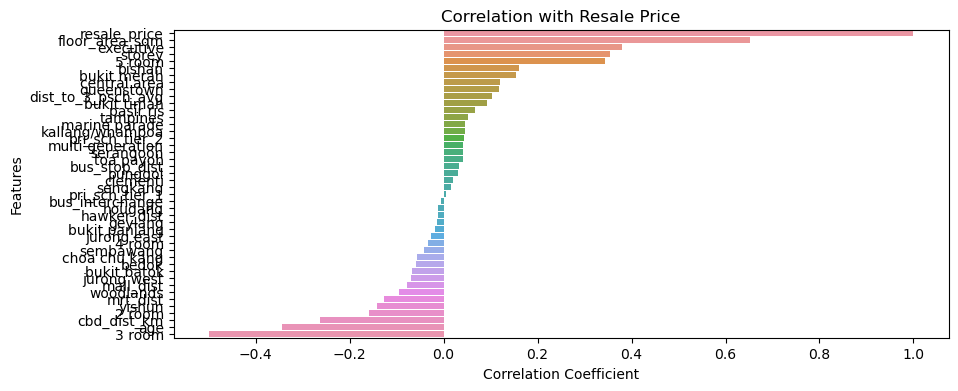

resale_price          1.000000
floor_area_sqm        0.652416
executive             0.380493
storey                0.353199
5 room                0.342626
bishan                0.160029
bukit merah           0.153121
central area          0.120204
queenstown            0.118515
dist_to_3_psch_avg    0.102459
bukit timah           0.091360
pasir ris             0.067207
tampines              0.051364
marine parade         0.045784
kallang/whampoa       0.045482
pri_sch_tier_2        0.042900
multi-generation      0.041378
serangoon             0.040744
toa payoh             0.040493
bus_stop_dist         0.033611
punggol               0.031327
clementi              0.018963
sengkang              0.016645
pri_sch_tier_1        0.005462
bus_interchange      -0.005715
hougang              -0.012386
hawker_dist          -0.012508
geylang              -0.014355
bukit panjang        -0.018838
jurong east          -0.025980
4 room               -0.034262
sembawang            -0.042451
choa chu

In [ ]:
# Plotting correlation coefficients to resale value

# Dropping columns that are not meaningful for correlation
hdb_num_filter = hdb_num.drop(columns=['pri_sch_lat', 'pri_sch_lon', 'lat', 'lon'])

# Compute the correlation matrix, including only numeric columns
corr_matrix = hdb_num_filter.corr()
# Focus on correlations with the target variable 'resale_price'
target_corr = corr_matrix['resale_price'].sort_values(ascending=False)
# Plot the correlations with the target variable
plt.figure(figsize=(10, 4))
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title('Correlation with Resale Price')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()
target_corr

### Feature Interaction 1
_Product of distance to city centre and age_
<br>
<br><font size='2'>By combining the age and distance to the city centre into a single feature interaction, we aim to capture the combined impact of these factors on the property's value.
For instance, older properties near city centre may face less depreciation over time, while newer properties near city centre may have a compounded effect on resale value
<br>
<br>Conversely, properties in the neighbourhood areas may offer affordability overall, but may face more depreciation over time</font>

In [ ]:
hdb_fam['urban_prox_x_age'] = hdb_fam['cbd_dist_km']*hdb_fam['age']
np.corrcoef(hdb_fam['urban_prox_x_age'], hdb_fam['resale_price'])[0, 1]


-0.41874353778176376

The product of distance to city centre and age proves to be a synergistic relationship as it has a stronger correlation coefficient (-0.42) than its individual features dist_to_cbd_km (-0.25), age(-0.35)

### Feature Interaction 2

_Age of unit and floor area_

In [ ]:
# First, since all HDBs are leased for 99 years, create a 'years_left' feature so that there's a positive correlation with resale value.

hdb_fam['years_left'] = 99-hdb_fam['age']

# Checking that the correlation coefficient is the same as age against resale price
print(f"Correlation coefficient of years left on lease against resale price: {np.corrcoef(hdb_fam['years_left'], hdb_fam['resale_price'])[0, 1]}")

Correlation coefficient of years left on lease against resale price: 0.345049122639563


In [ ]:
# Combined effect of years of lease left and floor area

hdb_fam['age_x_floor_area'] = hdb_fam['years_left']*hdb_fam['floor_area_sqm']
np.corrcoef(hdb_fam['age_x_floor_area'], hdb_fam['resale_price'])[0, 1]


0.6518549566402132

This interaction might not have a large impact on the model's performance as its correlation coefficient is not stronger than the correlation between floor area and resale value.

### Feature Interaction 3

_Age of unit and storey_

<br><font size='2'>By combining these two factors into a single interaction term, we can account for their joint influence on resale value more effectively. For example, properties with a high floor level and ample lease remaining may command premium prices due to the desirable combination of elevated views and long-term ownership potential.
<br>
<br>Conversely, properties with a low floor level and limited lease remaining may experience a compounded diminished resale value due to potential drawbacks associated with both factors.</font>

In [ ]:
# Combined effect of years of lease left and storey
hdb_fam['age_x_storey'] = hdb_fam['years_left']*hdb_fam['storey']
np.corrcoef(hdb_fam['age_x_storey'], hdb_fam['resale_price'])[0, 1]

0.4009417370460506

This combined effect shows a marginally higher correlation coefficient than its individual features.

### Feature Interaction 4

_Distance to amenities_

<br><font size='2'>By creating a new feature that calculates a distance score to other amenities than schools, we can account for the combined effect of the hdb's resale value more effectively. For example, if a unit has many amenities nearby (all within 200m), that unit should be more desirable by buyers thereby increasing the resale price. With 2 out of 4 amenities very near, it could be moderately desirable. With all 4 amenities (food, shopping, transport) very far, it could be less desirable.
<br>
<br>The score will not be a product of all amenities as some units have values of 0 to malls. In such cases, if it's very far from transport options, the combined effect by calculating the product will be misrepresenting the desired effect as the total score would be 0.

<br> In addition, I will also be assigning a weightage to distance from different amenities. As some have stronger correlation coefficients than others, suggesting that some amenities are more desirable than others.</font>

/Users/hongwei/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


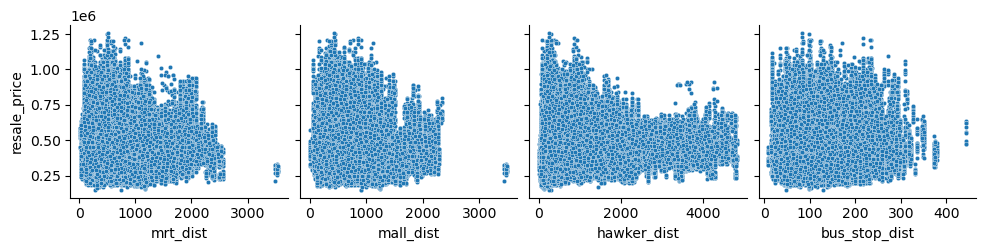

In [ ]:
# Looking at scatterplots of all 4 amenities distance to resale value

sns.pairplot(hdb_fam, y_vars=['resale_price'],
             x_vars=['mrt_dist', 'mall_dist', 'hawker_dist', 'bus_stop_dist'],
             plot_kws={'s':10})

In [ ]:
# Print the respective correlation coefficients

amenities_dist = hdb_fam[['resale_price', 'mrt_dist', 'mall_dist', 'hawker_dist', 'bus_stop_dist']]
amen_dist_corr = amenities_dist.corr()
amen_corr = amen_dist_corr['resale_price'].sort_values(ascending=False)
print(amen_corr)

resale_price     1.000000
bus_stop_dist    0.033611
hawker_dist     -0.012508
mall_dist       -0.077697
mrt_dist        -0.126877
Name: resale_price, dtype: float64


In [ ]:
# Combining the different distances to amenities by weightage based on the individual correlation coefficients

hdb_fam['amen_dist'] = (0.55*hdb_fam['mrt_dist']) + (0.35*hdb_fam['mall_dist']) + (0.05*hdb_fam['hawker_dist']) + (0.05*hdb_fam['bus_stop_dist'])

np.corrcoef(hdb_fam['amen_dist'], hdb_fam['resale_price'])[0, 1]

-0.14624370431960182

In [ ]:
# Selecting only numeric values for the model

hdb_num = hdb_fam.select_dtypes(include=['number'])
hdb_num.info()


<class 'pandas.core.frame.DataFrame'>
Index: 141233 entries, 0 to 149804
Data columns (total 53 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   floor_area_sqm      141233 non-null  float64
 1   resale_price        141233 non-null  float64
 2   storey              141233 non-null  int64  
 3   age                 141233 non-null  int64  
 4   lat                 141233 non-null  float64
 5   lon                 141233 non-null  float64
 6   mall_dist           141233 non-null  float64
 7   hawker_dist         141233 non-null  float64
 8   mrt_dist            141233 non-null  float64
 9   bus_interchange     141233 non-null  int64  
 10  bus_stop_dist       141233 non-null  float64
 11  pri_sch_lat         141233 non-null  float64
 12  pri_sch_lon         141233 non-null  float64
 13  pri_sch_tier_2      141233 non-null  int64  
 14  pri_sch_tier_1      141233 non-null  int64  
 15  2 room              141233 non-null  in

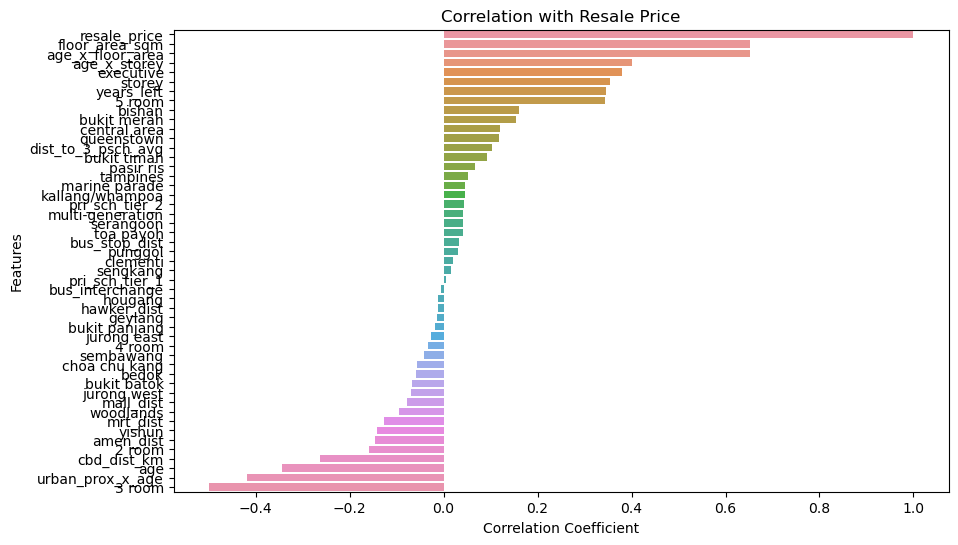

resale_price          1.000000
floor_area_sqm        0.652416
age_x_floor_area      0.651855
age_x_storey          0.400942
executive             0.380493
storey                0.353199
years_left            0.345049
5 room                0.342626
bishan                0.160029
bukit merah           0.153121
central area          0.120204
queenstown            0.118515
dist_to_3_psch_avg    0.102459
bukit timah           0.091360
pasir ris             0.067207
tampines              0.051364
marine parade         0.045784
kallang/whampoa       0.045482
pri_sch_tier_2        0.042900
multi-generation      0.041378
serangoon             0.040744
toa payoh             0.040493
bus_stop_dist         0.033611
punggol               0.031327
clementi              0.018963
sengkang              0.016645
pri_sch_tier_1        0.005462
bus_interchange      -0.005715
hougang              -0.012386
hawker_dist          -0.012508
geylang              -0.014355
bukit panjang        -0.018838
jurong e

In [ ]:
# Dropping columns that are not meaningful for correlation
hdb_num_filter = hdb_num.drop(columns=['pri_sch_lat', 'pri_sch_lon', 'lat', 'lon'])

# Compute the correlation matrix, including only numeric columns
corr_matrix = hdb_num_filter.corr()
# Focus on correlations with the target variable 'resale_price'
target_corr = corr_matrix['resale_price'].sort_values(ascending=False)
# Plot the correlations with the target variable
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title('Correlation with Resale Price')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()
target_corr

In [ ]:
# Exporting a new csv file that contains the engineered features

hdb_fam.to_csv('hdb_pri_sch_clean.csv', index=False)

NameError: name 'hdb_fam' is not defined